In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import models
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow import reshape
from tensorflow.image import resize_with_pad
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
import os
import numpy as np
%matplotlib inline

In [2]:
import sys

In [3]:
sys.path[0] = '/Users/nicksubic/Documents/flatiron/phase_1/nyc-mhtn-ds-091420-lectures/Phase_4/chest_xray/Pnuemonia-image-classification/src/modules/'

In [4]:
import graphs
import image_import

## Importing Data

In [5]:
def import_image(PATH, image_name):
    """
    PATH --> str: Relative path to image directoy
    image_name --> str: Name of the image to load
    Returns:
    PIL image
    """
    # create path to file
    img_path = PATH + "/" + image_name
    # load file and return pil
    return image.load_img(img_path) 

def grayscale_and_resize(PIL, shape=(256,256), padding=False, grayscale=True):
    """
    This is the preprocessing function that will take the raw jpeg, gray scale it, resize it and 
    turn it into an array
    PIL --> PIL object
    shape --> tuple: size of the final array
    padding --> bool: if True, will use tf.resize_with_pad
    """
    if padding:
        gray_image = rgb_to_grayscale(PIL)
        resized_image_arr = resize_with_pad(gray_image, target_height=shape[0], target_width=shape[1])
    else:
        if grayscale:
            resized_image_arr = img_to_array(PIL.convert(mode = 'L').resize(shape))
        else:
            resized_image_arr = img_to_array(PIL.resize(shape))
    return resized_image_arr

def import_image_to_array(
         RELPATH,
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(256,256),
         grayscale=True,
         test=False
):
    """
    This function loads all train, test and validation data into a dictionary of images
    Padding currently only returns a grayscale image.
    =====================================================================================
    RELPATH --> str: The relative path to the cwd to the directory containing image directories
    eg '../../src/data/chest_xray'
    =====================================================================================
    dir_names --> list, str: The names of the subdirectories containing the images
    eg ['train', 'test', 'val'] <-- default
    =====================================================================================
    sub_dir_names --> list -> str: names of the subdirectory containg postivie and negative cases
    eg ['NORMAL', 'PNEUMONIA'] <-- default
    =====================================================================================
    padding  --> bool: Whether you want the reshaping to be padded or not
    =====================================================================================
    shape --> tuple-> int: The final shape of the tensor array
    =====================================================================================  
    grayscale --> Bool: if True, images will be reduced to grayscale (x,x,1) else (x,x,3)
    returns
    dict --> str:list -> tuple -> (tf.array, bool)
    A dictionary where the keys are the dir_names and the values are lists containing tuple where 
    the first index is the tf.array and the second is a boolian, True if class is pnuemonia, false otherwise.
    """
    # test relative path works!! 
    PATH = os.getcwd() + RELPATH
    try:
        os.listdir(PATH)
        print("You're relative directory is good, proceeding to import files...", end="\n\n")
    except Exception as e:
        print(str(e))
        print(f"Your relative path directory is not pointing to the correct location. Double check your input \n")
        print("Terminating Program", end='\n')
        print("=======================================================================================")
        return False
    # instantiate a dict object and populate the keys
    image_dict = {}
    for name in dir_names:
        image_dict[name] = []
        print(f"Loading images from {name}", end='\n')
        # For each subdirectory, get all of the images and append to dictionary
        for sub_dir in sub_dir_names:
            subPATH = PATH + name + "/" + sub_dir
            # list of all image names in the subdirectory
            image_batch = os.listdir(subPATH)
            for image in image_batch:
                # import the image in pil format
                pil = import_image(subPATH, image)
                # gray scale and reshape the image turning it into an array
                gray_resized_pil = grayscale_and_resize(pil, shape=shape, padding=padding, grayscale=grayscale)
                # center the pixels
                centered_array = gray_resized_pil/255
                # append to the image_dict with class flag
                flag = 1
                if sub_dir == 'NORMAL':
                     flag = 0
                image_dict[name].append((image, centered_array, flag))
                # if this is just a test case, break out of this loop so we get one from each class
                if test == True:
                    break
            print(f"Finished loading images from {sub_dir}", end="\n")
        print()
    return image_dict

In [35]:
images = import_image_to_array('/../../../chest_xray/',
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(224,224), test=False, grayscale = False)

You're relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



In [55]:
# image.load_img('/Users/nicksubic/Documents/flatiron/phase_1/nyc-mhtn-ds-091420-lectures/Phase_4/chest_xray/train/PNEUMONIA/person467_virus_961.jpeg')

In [36]:
# virus = [i for i in filenames if i.find('virus') != -1]
# bacteria = [i for i in filenames if i.find('bacteria') != -1]

In [37]:
#list comprehensions to split the imported data into train/test/val 
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['val']])
y_val = np.array([i[2] for i in images['val']])

In [21]:
np.mean(images['train'])

array([[[0.4672247 , 0.4672247 , 0.4672247 ],
        [0.4721117 , 0.4721117 , 0.4721117 ],
        [0.48084137, 0.48084137, 0.48084137],
        ...,
        [0.48312163, 0.48312163, 0.48312163],
        [0.48252878, 0.48252878, 0.48252878],
        [0.4791454 , 0.4791454 , 0.4791454 ]],

       [[0.46659467, 0.46659467, 0.46659467],
        [0.47118452, 0.47118452, 0.47118452],
        [0.48055792, 0.48055792, 0.48055792],
        ...,
        [0.48044372, 0.48044372, 0.48044372],
        [0.48163873, 0.48163873, 0.48163873],
        [0.4793552 , 0.4793552 , 0.4793552 ]],

       [[0.4668799 , 0.4668799 , 0.4668799 ],
        [0.471656  , 0.471656  , 0.471656  ],
        [0.48089582, 0.48089582, 0.48089582],
        ...,
        [0.4841269 , 0.4841269 , 0.4841269 ],
        [0.48300895, 0.48300895, 0.48300895],
        [0.47879538, 0.47879538, 0.47879538]],

       ...,

       [[0.40611437, 0.40611437, 0.40611437],
        [0.4052843 , 0.4052843 , 0.4052843 ],
        [0.40709266, 0

## Modeling

In [69]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  1)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [70]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
105/105 [==============================] - 214s 2s/step - loss: 0.4960 - acc: 0.7749 - val_loss: 0.5299 - val_acc: 0.8125
Epoch 2/5
105/105 [==============================] - 190s 2s/step - loss: 0.3079 - acc: 0.8775 - val_loss: 0.9982 - val_acc: 0.6250
Epoch 3/5
105/105 [==============================] - 199s 2s/step - loss: 0.2106 - acc: 0.9181 - val_loss: 0.7651 - val_acc: 0.5625
Epoch 4/5
105/105 [==============================] - 199s 2s/step - loss: 0.1800 - acc: 0.9346 - val_loss: 0.3735 - val_acc: 0.8750
Epoch 5/5
105/105 [==============================] - 199s 2s/step - loss: 0.1694 - acc: 0.9342 - val_loss: 0.3962 - val_acc: 0.8125


In [72]:
results_test = cnn.evaluate(X_test, y_test)

20/20 [==============================] - 6s 307ms/step - loss: 0.5075 - acc: 0.7885


Not bad right out of the box. We borrowed some code from lecture to visualize our loss and accuracy.

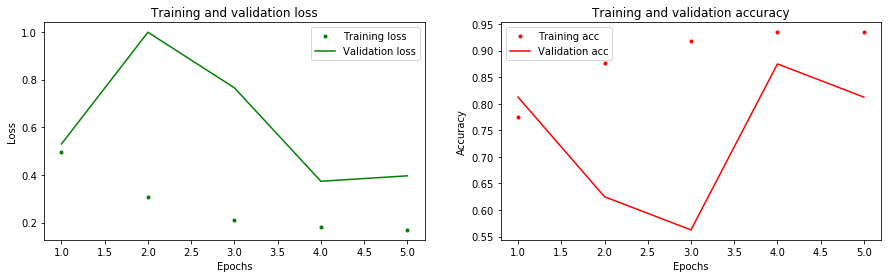

In [74]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Adding weights and dropouts, changing optimizers

In [13]:
# calculate inverse 
pnue_frequency = sum(y_train)/len(y_train)
inv_pnue_frequency = 1/pnue_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_pnue_frequency
}

For the second model we added dropout layers and two extra dense layers. We also changed our optimizer to Adam and our pooling to average. Finally, we added class weights.

In [108]:
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn4.add(layers.MaxPooling2D((2, 2)))
cnn4.add(layers.Dropout(.2))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))
cnn4.add(layers.Dropout(.2))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dropout(.2))
cnn4.add(layers.Dense(16, activation = 'relu'))
cnn4.add(layers.Dropout(.1))
cnn4.add(layers.Dense(32, activation = 'relu'))
cnn4.add(layers.Dense(1, activation='sigmoid'))

cnn4.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])

In [109]:
cnn5 = cnn4.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_test, y_test), class_weight = weights)

Epoch 1/5
105/105 [==============================] - 205s 2s/step - loss: 0.9621 - acc: 0.6977 - val_loss: 0.3959 - val_acc: 0.8173
Epoch 2/5
105/105 [==============================] - 204s 2s/step - loss: 0.3498 - acc: 0.9342 - val_loss: 0.6898 - val_acc: 0.7804
Epoch 3/5
105/105 [==============================] - 203s 2s/step - loss: 0.2589 - acc: 0.9542 - val_loss: 0.5054 - val_acc: 0.8285
Epoch 4/5
105/105 [==============================] - 202s 2s/step - loss: 0.2428 - acc: 0.9557 - val_loss: 0.6446 - val_acc: 0.7740
Epoch 5/5
105/105 [==============================] - 200s 2s/step - loss: 0.1705 - acc: 0.9684 - val_loss: 0.7460 - val_acc: 0.7981


In [110]:
results_test = cnn4.evaluate(X_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.2564 - acc: 0.9375


In [103]:
cnn6 = models.Sequential()
# Input layer conv
cnn6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn6.add(layers.MaxPooling2D((2, 2)))
# First hidden layer conv
cnn6.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D((2, 2)))
cnn6.add(layers.Flatten())
# Added first dense layer
cnn6.add(layers.Dense(32, activation='relu'))
cnn6.add(layers.Dropout(.2))
# Add Second Layer
cnn6.add(layers.Dense(16, activation='relu'))
cnn6.add(layers.Dropout(.1))
cnn6.add(layers.Dense(1, activation='sigmoid'))
cnn6.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc'])
cnn7 = cnn6.fit(X_train, y_train,
               epochs=5,
               batch_size=50,
               validation_data = (X_test, y_test), 
               class_weight=weights,
               verbose=True)

Epoch 1/5
105/105 [==============================] - 167s 2s/step - loss: 0.8071 - acc: 0.8037 - val_loss: 0.4315 - val_acc: 0.7804
Epoch 2/5
105/105 [==============================] - 175s 2s/step - loss: 0.3592 - acc: 0.9337 - val_loss: 0.5603 - val_acc: 0.7580
Epoch 3/5
105/105 [==============================] - 163s 2s/step - loss: 0.2519 - acc: 0.9546 - val_loss: 0.6264 - val_acc: 0.7676
Epoch 4/5
105/105 [==============================] - 163s 2s/step - loss: 0.2265 - acc: 0.9584 - val_loss: 0.6363 - val_acc: 0.7516
Epoch 5/5
105/105 [==============================] - 161s 2s/step - loss: 0.1532 - acc: 0.9747 - val_loss: 0.7020 - val_acc: 0.7804


In [104]:
results_test = cnn6.evaluate(X_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.1482 - acc: 0.9375


In [178]:
#saving models
from datetime import datetime
today = str(datetime.today()).split()[0]
directory = "../../models/"
model_id = "nick-5"
filename = directory+today+model_id+".HDF5"

In [179]:
cnn12.save(filename)

INFO:tensorflow:Assets written to: ../../models/2020-12-01nick-5.HDF5/assets


In [150]:
cnn8 = keras.models.load_model('Pnuemonia-image-classification/models/2020-12-011.HDF5')


In [154]:
results_test = cnn8.evaluate(X_test, y_test)

20/20 [==============================] - 5s 244ms/step - loss: 0.9421 - acc: 0.7532


Here we switched the metric to recall and upped the dropout to .5 in hopes of minimizing overfit.

In [158]:
cnn10 = models.Sequential()
cnn10.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn10.add(layers.MaxPooling2D((2, 2)))
cnn10.add(layers.Dropout(.5))
cnn10.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn10.add(layers.MaxPooling2D((2, 2)))
cnn10.add(layers.Dropout(.5))
cnn10.add(layers.Flatten())
cnn10.add(layers.Dense(32, activation='relu'))
cnn10.add(layers.Dropout(.5))
cnn10.add(layers.Dense(16, activation = 'relu'))
cnn10.add(layers.Dropout(.3))
cnn10.add(layers.Dense(32, activation = 'relu'))
cnn10.add(layers.Dense(1, activation='sigmoid'))

cnn10.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['Recall'])

In [159]:
cnn11 = cnn10.fit(X_train, y_train,
               epochs=10,
               batch_size=50,
               validation_data = (X_test, y_test), 
               class_weight=weights,
               verbose=True)

Epoch 1/10
105/105 [==============================] - 202s 2s/step - loss: 1.4018 - recall: 0.3832 - val_loss: 0.6194 - val_recall: 0.4051
Epoch 2/10
105/105 [==============================] - 201s 2s/step - loss: 0.8255 - recall: 0.8000 - val_loss: 0.3758 - val_recall: 0.9308
Epoch 3/10
105/105 [==============================] - 202s 2s/step - loss: 0.6050 - recall: 0.8854 - val_loss: 0.3552 - val_recall: 0.8564
Epoch 4/10
105/105 [==============================] - 202s 2s/step - loss: 0.4551 - recall: 0.9308 - val_loss: 0.5162 - val_recall: 0.9872
Epoch 5/10
105/105 [==============================] - 203s 2s/step - loss: 0.3658 - recall: 0.9414 - val_loss: 0.7797 - val_recall: 0.9795
Epoch 6/10
105/105 [==============================] - 203s 2s/step - loss: 0.3572 - recall: 0.9445 - val_loss: 0.6419 - val_recall: 0.9821
Epoch 7/10
105/105 [==============================] - 199s 2s/step - loss: 0.3182 - recall: 0.9489 - val_loss: 0.5994 - val_recall: 0.9872
Epoch 8/10
105/105 [=======

In [160]:
results_test = cnn10.evaluate(X_test, y_test)

20/20 [==============================] - 4s 217ms/step - loss: 0.8481 - recall: 0.9872


In [161]:
results_val = cnn10.evaluate(X_val, y_val)

1/1 [==============================] - 0s 867us/step - loss: 0.1577 - recall: 1.0000


Our best results yet. The model performed perfectly on the validation set.

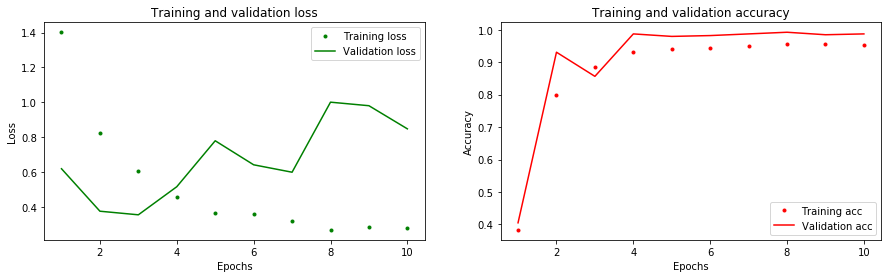

In [165]:
hist_cnn = cnn11.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['recall'] 
val_acc_values = hist_cnn['val_recall']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
cnn12 = models.Sequential()
cnn12.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn12.add(layers.MaxPooling2D((2, 2)))
cnn12.add(layers.Dropout(.5))
cnn12.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn12.add(layers.MaxPooling2D((2, 2)))
cnn12.add(layers.Dropout(.5))
cnn12.add(layers.Flatten())
cnn12.add(layers.Dense(32, activation='relu'))
cnn12.add(layers.Dropout(.5))
cnn12.add(layers.Dense(16, activation = 'relu'))
cnn12.add(layers.Dropout(.3))
cnn12.add(layers.Dense(32, activation = 'relu'))
cnn12.add(layers.Dense(1, activation='sigmoid'))

cnn12.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['AUC', 'Recall', 'acc'])

For this last model, we changed the metric to AUC but left everything else the same. Again, it performed perfectly on the validation set but did worse on the test data. Still, very good results overall.

In [30]:
cnn13 = cnn12.fit(X_train, y_train,
               epochs=10,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True)

Epoch 1/10
105/105 [==============================] - 189s 2s/step - loss: 1.3963 - auc: 0.5090 - recall: 0.5319 - acc: 0.5196 - val_loss: 0.6931 - val_auc: 0.5000 - val_recall: 0.7500 - val_acc: 0.5000
Epoch 2/10
105/105 [==============================] - 189s 2s/step - loss: 1.3855 - auc: 0.5363 - recall: 0.6666 - acc: 0.5982 - val_loss: 0.6874 - val_auc: 0.6328 - val_recall: 0.6250 - val_acc: 0.6875
Epoch 3/10
105/105 [==============================] - 189s 2s/step - loss: 0.9910 - auc: 0.8576 - recall: 0.7525 - acc: 0.7715 - val_loss: 0.5597 - val_auc: 0.8438 - val_recall: 0.7500 - val_acc: 0.6875
Epoch 4/10
105/105 [==============================] - 180s 2s/step - loss: 0.5316 - auc: 0.9609 - recall: 0.8766 - acc: 0.8919 - val_loss: 0.3086 - val_auc: 0.9062 - val_recall: 0.8750 - val_acc: 0.8750
Epoch 5/10
105/105 [==============================] - 188s 2s/step - loss: 0.3999 - auc: 0.9762 - recall: 0.9053 - acc: 0.9155 - val_loss: 0.2869 - val_auc: 0.9688 - val_recall: 0.8750 - v

In [31]:
results_test = cnn12.evaluate(X_test, y_test)

20/20 [==============================] - 5s 232ms/step - loss: 0.6530 - auc: 0.9033 - recall: 0.9821 - acc: 0.7660


In [19]:
cnn12.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0

In [11]:
X_train[0].shape

(224, 224, 1)

In [27]:
np.random.seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

cnn14 = models.Sequential()
# Input layer conv
cnn14.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  1)))
cnn14.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn14.add(layers.MaxPooling2D((2, 3)))
# First hidden layer conv
cnn14.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn14.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn14.add(layers.MaxPooling2D((2, 3)))

cnn14.add(layers.Conv2D(16, (6, 6), activation='relu'))
cnn14.add(layers.MaxPooling2D((2, 3)))

cnn14.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn14.add(layers.MaxPooling2D((2, 3)))

cnn14.add(layers.Flatten())

cnn14.add(layers.Dense(64, activation='relu'))
cnn14.add(layers.Dropout(.5))

cnn14.add(layers.Dense(32, activation='relu'))
cnn14.add(layers.Dropout(.3))
cnn14.add(layers.Dense(16, activation='relu'))
cnn14.add(layers.Dropout(.1))
cnn14.add(layers.Dense(1, activation='sigmoid'))
cnn14.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc', 'Recall', 'AUC'])
cnn15 = cnn14.fit(X_train, y_train,
               epochs=10,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True,
               callbacks = callback)


Epoch 1/10
105/105 [==============================] - 424s 4s/step - loss: 1.3873 - acc: 0.5238 - recall: 0.5412 - auc: 0.5171 - val_loss: 0.6925 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.6875
Epoch 2/10
105/105 [==============================] - 434s 4s/step - loss: 1.1057 - acc: 0.6756 - recall: 0.6506 - auc: 0.7873 - val_loss: 0.4634 - val_acc: 0.7500 - val_recall: 0.7500 - val_auc: 0.8594
Epoch 3/10
105/105 [==============================] - 419s 4s/step - loss: 0.6316 - acc: 0.8831 - recall: 0.8854 - auc: 0.9411 - val_loss: 0.5104 - val_acc: 0.7500 - val_recall: 1.0000 - val_auc: 0.8594
Epoch 4/10
105/105 [==============================] - 438s 4s/step - loss: 0.4501 - acc: 0.9179 - recall: 0.9166 - auc: 0.9691 - val_loss: 0.5019 - val_acc: 0.8750 - val_recall: 1.0000 - val_auc: 0.8516
Epoch 5/10
105/105 [==============================] - 432s 4s/step - loss: 0.4047 - acc: 0.9264 - recall: 0.9234 - auc: 0.9750 - val_loss: 0.5260 - val_acc: 0.6875 - val_recall: 1.0000

In [28]:
results_test = cnn14.evaluate(X_test, y_test)
# .5197, .7997, .9821, .9205 before removing convolution dropouts and upping dropouts in dense layers

20/20 [==============================] - 11s 561ms/step - loss: 0.5738 - acc: 0.7853 - recall: 0.9769 - auc: 0.9078


In [63]:
def plot_loss(history):
    '''     '''
    epochs = range(1, len(history['loss']) + 1)

    fig, ax = plt.subplots(2,2, figsize=(15, 12))
    
    ax[0,0].plot(epochs, history['loss'], 'g.', label='Training loss')
    ax[0,0].plot(epochs, history['val_loss'], 'g', label='Validation loss')

    ax[0,0].set_title('Training and validation loss')
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].legend()

    ax[0,1].plot(epochs, history['auc'], 'r.', label='Training auc')
    ax[0,1].plot(epochs, history['val_auc'], 'r', label='Validation auc')
    ax[0,1].set_title('Training and validation AUC')
    ax[0,1].set_xlabel('Epochs')
    ax[0,1].set_ylabel('AUC')

    ax[1,0].plot(epochs, history['acc'], 'b.', label='Training Accuracy')
    ax[1,0].plot(epochs, history['val_acc'], 'b', label='Validation Accuracy')
    ax[1,0].set_title('Training and validation Accuracy')
    ax[1,0].set_xlabel('Epochs')
    ax[1,0].set_ylabel('Accuracy')

    ax[1,1].plot(epochs, history['recall'], 'y.', label='Training Recall')
    ax[1,1].plot(epochs, history['val_recall'], 'y', label='Validation Recall')
    ax[1,1].set_title('Training and validation Recall')
    ax[1,1].set_xlabel('Epochs')
    ax[1,1].set_ylabel('Recall')

    plt.legend()
    return plt.show()

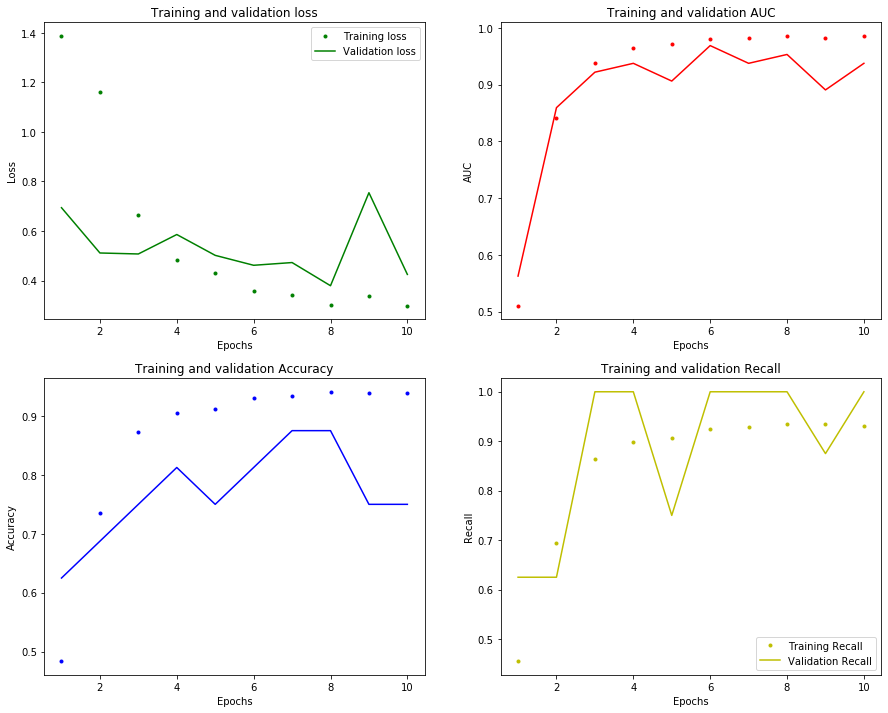

In [64]:
plot_loss(cnn15.history)

In [46]:
def get_labels(fit_model, X, threshold):
    return [1 if x >= threshold else 0 for x in fit_model.predict(X)]
def get_false_positive(true, prediction):
    return [1 if (x == 0 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_true_positive(true, prediction):
    return [1 if (x == 1 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_false_negative(true, prediction):
    return [1 if (x == 1 and y == 0) else 0 for x,y in zip(true,prediction)]

In [47]:
predictions = get_labels(cnn14, X_test, 0.5)
fp = get_false_positive(y_test, predictions)
tp = get_true_positive(y_test, predictions)

ValueError: in user code:

    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_11 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 224, 224, 3]


In [76]:
def plot_cmatrix(actual, predictions):
    cmatrix = confusion_matrix(actual, predictions)

    fig, ax = plt.subplots(figsize = (12,6))
    sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Healthy', 'Pneumonia'])
    ax.set_yticklabels(['Healthy', 'Pneumonia'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    ax.set_title('Confusion Matrix for CNN Predictions', size =18)
  
    return plt.show()


In [45]:
graphs.plot_cmatrix(y_test, predictions)

NameError: name 'predictions' is not defined

In [100]:
p = cnn14.predict(X_test)

In [103]:
# p = [i[0] for i in p]
fpr, tpr, threshholds = roc_curve(y_test, p)

In [9]:
np.random.seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

cnn16 = models.Sequential()

cnn16.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 1)))
cnn16.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn16.add(layers.MaxPooling2D((2, 2)))

cnn16.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(112, 112, 1)))
cnn16.add(layers.Conv2D(128, (3,3), activation='relu'))
cnn16.add(layers.MaxPooling2D((2, 2)))

cnn16.add(layers.Conv2D(256, (3,3), activation='relu', input_shape=(56,56,1)))
cnn16.add(layers.Conv2D(256, (3,3), activation='relu'))
cnn16.add(layers.Conv2D(256, (3,3), activation='relu'))
cnn16.add(layers.MaxPooling2D((2, 2)))

cnn16.add(layers.Conv2D(512, (3,3), activation='relu', input_shape=(28,28,1)))
cnn16.add(layers.Conv2D(512, (3,3), activation='relu'))
cnn16.add(layers.Conv2D(512, (3,3), activation='relu'))
cnn16.add(layers.MaxPooling2D((2, 2)))

cnn16.add(layers.Conv2D(512, (3,3), activation='relu', input_shape=(14,14,1)))
cnn16.add(layers.Conv2D(512, (3,3), activation='relu'))
cnn16.add(layers.Conv2D(512, (3,3), activation='relu'))
cnn16.add(layers.MaxPooling2D((2, 2)))

cnn16.add(layers.Flatten())

cnn16.add(layers.Dense(512, activation='relu'))
cnn16.add(layers.Dropout(.5))
cnn16.add(layers.Dense(256, activation='relu'))
cnn16.add(layers.Dropout(.5))

cnn16.add(layers.Dense(1, activation='sigmoid'))
cnn16.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc', 'Recall', 'AUC'])

In [133]:
cnn17 = cnn16.fit(X_train, y_train,
               epochs=5,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True)

Epoch 1/5
105/105 [==============================] - 1402s 13s/step - loss: 1.4152 - acc: 0.6863 - recall: 0.8834 - auc: 0.5023 - val_loss: 0.6934 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/5
105/105 [==============================] - 1411s 13s/step - loss: 1.3877 - acc: 0.4998 - recall: 0.5063 - auc: 0.4872 - val_loss: 0.6934 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/5
105/105 [==============================] - 1405s 13s/step - loss: 1.3868 - acc: 0.5288 - recall: 0.5657 - auc: 0.4958 - val_loss: 0.6932 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 4/5
 27/105 [======>.......................] - ETA: 17:10 - loss: 1.3950 - acc: 0.3696 - recall: 0.2437 - auc: 0.4748

KeyboardInterrupt: 

In [130]:
results_test = cnn16.evaluate(X_test, y_test)

20/20 [==============================] - 48s 2s/step - loss: 0.6919 - acc: 0.6250 - recall: 1.0000 - auc: 0.5000


Building a model using pretrained convolution layers from VGG16 and adding a flatten layer, two densely connected layers with dropouts and a sigmoid output. 

In [39]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [40]:
for layer in base_model.layers:
    layer.trainable = False
#making the existing layers untrainable in order to preserve them

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a second fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(.3)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

In [42]:
vgghist = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size=50, class_weight=weights, callbacks= callback)

Epoch 1/10
105/105 [==============================] - 619s 6s/step - loss: 0.8223 - acc: 0.8806 - recall: 0.8818 - auc: 0.9379 - val_loss: 0.2765 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 0.9844
Epoch 2/10
105/105 [==============================] - 608s 6s/step - loss: 0.2364 - acc: 0.9572 - recall: 0.9561 - auc: 0.9899 - val_loss: 0.0983 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/10
105/105 [==============================] - 602s 6s/step - loss: 0.1959 - acc: 0.9643 - recall: 0.9613 - auc: 0.9934 - val_loss: 0.1600 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/10
105/105 [==============================] - 616s 6s/step - loss: 0.1633 - acc: 0.9672 - recall: 0.9657 - auc: 0.9957 - val_loss: 0.1063 - val_acc: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/10
105/105 [==============================] - 634s 6s/step - loss: 0.1710 - acc: 0.9657 - recall: 0.9636 - auc: 0.9951 - val_loss: 0.2367 - val_acc: 0.9375 - val_recall: 1.0000 - v

In [43]:
results_test = model.evaluate(X_test, y_test)

20/20 [==============================] - 69s 3s/step - loss: 0.5288 - acc: 0.8413 - recall: 0.9949 - auc: 0.9466


In [48]:
predictions = get_labels(model, X_test, 0.5)

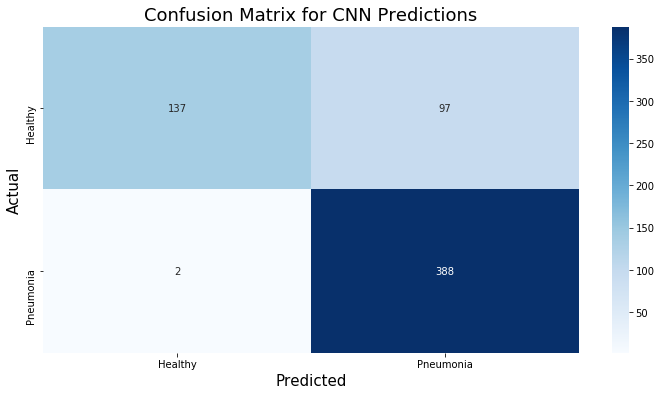

In [49]:
graphs.plot_cmatrix(y_test, predictions)